<b>Import dependencies</b>

In [1]:
import numpy as np
import copy 
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from data_processing import load_dataset

<b>Get datasets</b>

In [2]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In [4]:
# overview the dataset

print(f'training data shape: {train_set_x_orig.shape}')
print(f'training label shape: {train_set_y_orig.shape}')
print(f'test data shape: {test_set_x_orig.shape}')
print(f'test label shape: {test_set_y_orig.shape}')
print(f'training data in total: {len(train_set_x_orig)}')
print(f'test data in total: {len(test_set_x_orig)}')
print(f'total classes: {classes}')

training data shape: (209, 64, 64, 3)
training label shape: (1, 209)
test data shape: (50, 64, 64, 3)
test label shape: (1, 50)
training data in total: 209
test data in total: 50
total classes: [b'non-cat' b'cat']


clearly, its b'non-cat'


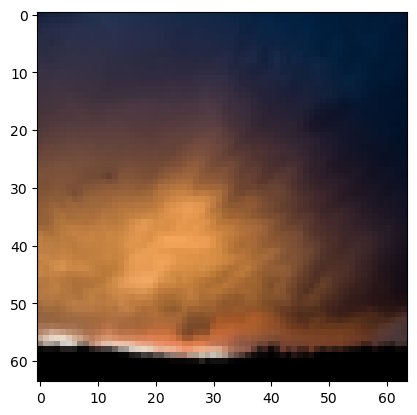

In [9]:
# check one example

index = 0
plt.imshow(train_set_x_orig[index])
print(f'clearly, its {classes[index]}')

In [16]:
# reshape the image 

train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
train_set_y = train_set_y_orig.reshape(train_set_y_orig.shape[0], -1)
test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_set_y = test_set_y_orig.reshape(test_set_y_orig.shape[0], -1)

In [18]:
print(f'training data shape: {train_set_x.shape}')
print(f'training label shape: {train_set_y.shape}')
print(f'test data shape: {test_set_x.shape}')
print(f'test label shape: {test_set_y.shape}')

training data shape: (12288, 209)
training label shape: (1, 209)
test data shape: (12288, 50)
test label shape: (1, 50)


<b>Build the Network</b>

<b>Helper functions</b>

In [20]:
def sigmoid(z):
    '''
    compute sigmoid of input
    
    Args:
    x -- numpy array
    
    return:
    fx -- numpy array
    '''
    
    return 1 / (1 + np.exp(-z))

In [22]:
# test sigmoid function

z = np.random.randn(1,3)
print(f'sigmoid of z: {sigmoid(z)}')

sigmoid of z: [[0.84859158 0.50486664 0.27813871]]


<b>Initialize parameters</b>

In [78]:
# init weights and bias with zeros
W = np.random.randn(train_set_x.shape[0])
b = np.random.randn(train_set_x.shape[1])
print(f'weigths:\n {W} and shape: {W.shape}')
print(f'bias:\n {b} and shape: {b.shape}')

weigths:
 [ 2.14737546  1.9447021   1.37272728 ...  0.24169549 -1.77309053
  0.36976594] and shape: (12288,)
bias:
 [-0.65049738 -0.25846468  1.48110358  0.73849391 -1.44207058 -0.88909773
 -0.44047805 -1.33374131 -1.89331462 -0.62936396  0.08772932  1.86850844
  0.40228092 -0.93856982 -0.77735944  1.42975584  0.21159007  0.21572124
 -1.57363618  1.25029238  1.0266538   0.48199734  0.72470897  1.13021754
  1.00484991 -1.18554711 -1.43311436  1.20147355 -1.0675913   0.84421234
  1.51808055 -1.13863916 -1.94091484  0.90391802 -1.33811167 -0.72376481
 -0.29603755 -0.94152884 -1.48343352 -1.00225814 -0.6639329  -1.19401927
 -0.76823679  1.25013863 -1.02703294  0.32378868 -0.57491077 -1.50659698
  0.12381704 -0.59462963 -1.00182219 -1.38252862 -0.13039296 -0.96629683
 -0.27284912  0.98343818  0.92652258 -0.14365174 -0.55181721 -0.67934231
 -1.00346898  1.30582124 -0.52435481  0.05741005 -0.48939728 -0.18096249
 -0.98689704 -0.26366157 -0.62891494 -0.21795937  0.42522727  0.10326338
  1.4086

<b>Forward and Backward Propagation</b>

In [79]:
def propagation(X, W, b, y):
    '''
    perform a single pass forward and backward propagation
    
    Args:
    X -- numpy array of input
    W -- numpy array of weights
    b -- numpy array of bias
    
    return:
    cache -- a dictionary stores forward loss and backward backward gradient
    '''
    
    Z = np.dot(W.T, X) + b
    fx = sigmoid(Z)
    loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
    cost = np.sum(loss)
    
    dW = (fx * (1-fx)).dot(X.T)
    db = fx * (1-fx)

    cache = {
        'cost': cost,
        'dW': dW,
        'db': db,
    }
    
    return cache

In [80]:
# test forward pass
cache = propagation(train_set_x, W, b, train_set_y)

print(f"cost: {cache['cost']}")

cost: nan


/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/3294255127.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/668532830.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/668532830.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)


In [81]:
# gradient descent

def optimize(X, y, W, b, learning_rate, num_iter, propagation_fn):
    '''
    update weights and bias in gradient descent
    
    Args:
    cache -- information about dW and db
    
    return:
    W, b -- updated weights and bias
    '''
    
    W = copy.deepcopy(W)
    b = copy.deepcopy(b)
    
    cost_history = []
    dW_history = []
    db_history = []
    
    for i in range(num_iter):
        cache = propagation(X, W, b, y)
        cost = cache['cost']
        dW = cache['dW']
        db = cache['db']
        W = W - dW * learning_rate
        b = b - db * learning_rate
        print(cost)
        cost_history.append(cost)
        dW_history.append(dW)
        db_history.append(db)
        
    return cost_history, dW_history, db_history

In [82]:
# test optimize
learning_rate = 0.01
iteration_number = 10
cost_history, dW_history, db_history = optimize(train_set_x, train_set_y, W, b, learning_rate, iteration_number, propagation(train_set_x, W, b, train_set_y))
#print(f'cost:\n {cost_history}')
#print(f'weights gradient:\n {dW_history}')
#print(f'bias gradient:\n {db_history}')

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/3294255127.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/668532830.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_17696/668532830.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
